In [57]:
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import math
import gymnasium as gym
from IPython import display

In [58]:
%matplotlib inline
plt.ion()

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
# Определяем параметры алгоритма Q-Learning и обучения.
params = {
    'batch_size': 128, # Размер пакета для обучения нейронной сети.
    'sequence_size': 5, # Размер последовательности для обучения.
    'gamma': 0.99, # Дисконтный фактор для учитывания будущих вознаграждений.
    'epsilon_start': 1.0, # Начальное значение параметра исследования.
    'epsilon_end': 0.1, # Конечное значение параметра исследования.
    'epsilon_decay': 1_000_000, # Сколько шагов займет уменьшенее параметра исследования.
    'target_update': 8000, # Частота обновления целевой нейронной сети.
    'momentum': 0.95, # Параметр момента для оптимизатора.
    'learning_rate': 2.5e-4, # Скорость обучения для оптимизатора.
    'n_actions': 5, # Количество доступных действий в среде.
    'avoided_steps': 80, # Количество шагов в начале, которые нужно пропустить.
    'dead_steps': 36, # Количество шагов после смерти игрока, которое нужно пропустить.
    'rewards': {
        "lose": -0.43, # Вознаграждение за поражение.
        "win": 10, # Вознаграждение за победу.
    }
}


In [61]:
# Создаем именованный кортеж Transition для представления перехода в памяти.
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'done'))
# Создаем класс ReplayMemory для хранения и управления памятью для обучения.
class ReplayMemory(object):
    def __init__(self, capacity):
        # Инициализируем очередь с максимальной длиной capacity.
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        # Добавляем новый переход в конец очереди.
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        # Случайным образом выбираем пакет переходов для обучения.
        return random.sample(self.memory, batch_size)
    def __len__(self):
        # Возвращаем текущую длину памяти (количество сохраненных переходов).
        return len(self.memory)

In [62]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Первый сверточный слой
        self.convolution1 = nn.Conv2d(in_channels=n_observations, 
                                    out_channels=32, 
                                    kernel_size=(4, 4), 
                                    stride=2, padding=2)
        # Второй сверточный слой
        self.convolution2 = nn.Conv2d(in_channels=32, 
                                      out_channels=32, 
                                      kernel_size=(2, 2), 
                                      stride=2, 
                                      padding=0)
        # Нормализация для первого сверточного слоя
        self.norm1 = nn.BatchNorm2d(32)
        # Нормализация для второго сверточного слоя
        self.norm2 = nn.BatchNorm2d(32)
        # Полносвязный скрытый слой 1
        self.hidden1 = nn.Linear(32 * 11 * 10, 512)
        # Полносвязный скрытый слой 2
        self.hidden2 = nn.Linear(512, 128)
        # Выходной слой сети
        self.output = nn.Linear(128, n_actions)
    def forward(self, x):
        # Применяем функцию активации ReLU к первому сверточному слою и нормализуем
        x = F.relu(self.norm1(self.convolution1(x)))
        # Применяем функцию активации ReLU ко второму сверточному слою и нормализуем
        x = F.relu(self.norm2(self.convolution2(x)))
        # Выпрямляем данные перед передачей их в полносвязные слои
        x = torch.flatten(x, start_dim=1)
        # Применяем функцию активации ReLU к первому скрытому слою
        x = F.relu(self.hidden1(x))
        # Применяем функцию активации ReLU ко второму скрытому слою
        x = F.relu(self.hidden2(x))
        # Выходной слой
        return self.output(x)

In [65]:
# Создаем класс Agent для управления агентом, обучающимся с использованием Q-Learning.
class Agent:
    def __init__(self, env, policy, target, memory):
        # Инициализируем агента с заданными параметрами и объектами.
        self.env = env # Среда, в которой агент будет обучаться.
        self.policy = policy # Нейронная сеть, представляющая стратегию агента.
        self.target = target # Целевая нейронная сеть для обновления Q-значений.
        self.memory = memory # Память для хранения и выборки переходов.
        self.display_data = {'q_mean': [], 'rewards_mean': [], 'rewards_sum': [], 'durations': []}
        self.learn_counter = self.episode_counter = self.steps_counter = 0
        # Определяем оптимизатор для обучения нейронной сети.
        self.optimizer = torch.optim.SGD(self.policy.parameters(), lr=params['learning_rate'], momentum=params['momentum'], nesterov=True)
        self.axis = None
        
    # Выбираем действие с учетом стратегии и параметра исследования.
    def select_action(self, state):
        # Рассчитываем текущее значение параметра исследования.
        eps_threshold = params['epsilon_end'] + (params['epsilon_start'] - params['epsilon_end']) * math.exp(-1. * self.steps_counter / params['epsilon_decay'])
        self.steps_counter += 1
        # Вычисляем Q-значения для всех доступных действий в текущем состоянии.
        with torch.no_grad():
            q_values = self.policy(state)
        # Записываем максимальное Q-значение для мониторинга.
        self.current_data['qs'].append(q_values.max(1)[0].item())
        # Принимаем решение о выборе действия на основе стратегии.
        if random.random() > eps_threshold:
            # Если случайное число больше epsilon, выбираем наилучшее известное действие (эксплорация).
            return q_values.max(1)[1].view(1, 1)
        else:
            # В противном случае выбираем случайное действие (исследование).
            return torch.tensor([[random.randrange(params['n_actions'])]], device=device, dtype=torch.long)
        
    # Предобрабатываем наблюдение из среды перед использованием в нейронной сети.
    def preprocess_observation(self, observation):
        # Преобразование наблюдения в тензор, усреднение каналов и обрезка.
        observation = torch.tensor(observation, dtype=torch.uint8, device=device)
        observation = observation.float().mean(dim=2).type(torch.uint8)[1:171]
        # Добавление "рамки" к изображению и уменьшение разрешения.
        border = torch.full((2, 160), 150).to(device)
        observation = torch.cat([border, observation, border])[1::4, 1::4]
        # Преобразование результата в матрицу чисел с плавающей точкой.
        return observation.float()
    
    # Инициализация графической визуализации с настройкой подграфиков
    def visualize(self):
        # Проверяем, были ли созданы субграфики ранее. Если нет, создаем их.
        if self.axis is None:
            self.figure, self.axis = plt.subplots(2, 2, figsize=(20, 10))
            self.figure.tight_layout(pad=3.0)
        # Очистка и построение графиков для разных метрик обучения в разных субграфиках.
        # Субграфик 1: График средних наград по эпизодам.
        self.axis[0, 0].clear()
        self.axis[0, 0].plot(self.display_data['rewards_mean'])
        self.axis[0, 0].set_xlabel('episode')
        self.axis[0, 0].set_ylabel('rewards_mean')
        # Субграфик 2: График средних значений Q-функции по эпизодам.
        self.axis[0, 1].clear()
        self.axis[0, 1].plot(self.display_data['q_mean'])
        self.axis[0, 1].set_xlabel('episode')
        self.axis[0, 1].set_ylabel('q_mean')
        # Субграфик 3: График суммарных наград по эпизодам.
        self.axis[1, 0].clear()
        self.axis[1, 0].plot(self.display_data['rewards_sum'])
        self.axis[1, 0].set_xlabel('episode')
        self.axis[1, 0].set_ylabel('rewards_sum')
        # Субграфик 4: График длительности эпизодов.
        self.axis[1, 1].clear()
        self.axis[1, 1].plot(self.display_data['durations'])
        self.axis[1, 1].set_xlabel('episode')
        self.axis[1, 1].set_ylabel('durations')
        # Отображение обновленных графиков и очистка вывода для интерактивной визуализации.
        plt.pause(0.001)
        display.display(self.figure)
        display.clear_output(wait=True)
            
        
    # Оптимизация нейронной сети агента методом обратного распространения ошибки.
    def optimize_model(self):
        # Проверяем, есть ли достаточно данных в памяти для обучения (проверка на минимальный размер пакета).
        if len(self.memory) < params['batch_size']:
            return
        # Получаем случайные переходы (состояния, действия, награды, следующие состояния и флаги завершения) из памяти.
        transitions = self.memory.sample(params['batch_size'])
        batch = Transition(*zip(*transitions))
        # Разбираем переходы и создаем тензоры для состояний, действий, следующих состояний, наград и флагов завершения.
        states = torch.stack(batch.state).squeeze(1)
        actions = torch.cat(batch.action)
        next_states = torch.stack(batch.next_state).squeeze(1)
        rewards = torch.stack(batch.reward).squeeze(1)
        dones = torch.tensor(batch.done).to(device)
        # Вычисляем ожидаемые целевые значения Q-функции и текущие предсказанные значения Q-функции для выбранных действий.
        predicted_targets = self.policy(states).gather(1, actions).to(device)
        target_values = self.target(next_states).detach().max(1)[0].to(device)
        # Вычисляем целевые метки для обучения, учитывая дисконтированные награды и флаги завершения эпизодов.
        labels = rewards + params['gamma'] * (~dones) * target_values
        # Вычисляем функцию потерь с помощью Smooth L1 Loss.
        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(predicted_targets, labels.detach().unsqueeze(1)).to(device)
        # Обнуляем градиенты и применяем обратное распространение ошибки.
        self.optimizer.zero_grad()
        loss.backward()
        # Ограничиваем значения градиентов для стабильности обучения.
        for param in self.policy.parameters():
            param.grad.data.clamp_(-1, 1)
        # Применяем градиенты, выполняя оптимизацию нейронной сети.
        self.optimizer.step()                                                                                                                           

    # Запуск одного эпизода в среде.
    def run_episode(self):
        # Инициализация данных текущего эпизода (графики, наград, наблюдений).
        self.current_data = {'qs': [], 'rewards': [], 'observations': []}
        # Функция для преобразования награды (подобие Leaky-ReLU).
        def transform_reward(reward):
            return math.log(reward, 1000) if reward > 0 else reward
        # Увеличение счетчика эпизодов.
        self.episode_counter += 1
        # Сброс среды и получение начального наблюдения и информации.
        observation, info = self.env.reset()
        # Пропуск начальных шагов для искусственного ускорения эпизода.
        for _ in range(params['avoided_steps']):
            self.env.step(3)
        # Первый "настоящий" шаг в эпизоде для получения начального состояния.
        observation, reward, terminated, _, info = self.env.step(3)
        state = self.preprocess_observation(observation)
        # Создание очереди состояний для последовательных кадров.
        previous_states = deque([state] * params['sequence_size'], maxlen=params['sequence_size'])
        # Функция для получения последовательности состояний.
        def get_state():
            return torch.stack(list(previous_states)).unsqueeze(0)
        # Флаг для отслеживания наличия награды в текущем эпизоде.
        has_reward = False
        # Кеширование количества оставшихся жизней.
        lives_cache = info["lives"]
        # Основной цикл для выполнения шагов в эпизоде.
        for t in count():
            # Получение текущего состояния.
            states = get_state()
            # Выбор действия на основе текущего состояния (стратегия и epsilon-greedy).
            action = self.select_action(states)
            # Выполнение выбранного действия в среде и получение наблюдения и награды.
            observation, reward, terminated, truncated, info = self.env.step(action)
            # Запись текущего наблюдения в данные эпизода.
            self.current_data['observations'].append(observation)
            self.current_data['rewards'].append(reward)
            # Преобразование награды (например, логарифмирование, если награда положительная).
            reward = transform_reward(reward)
            # Учет изменений в количестве жизней и наград.
            if info["lives"] < lives_cache:
                has_reward = False
                reward += params['rewards']['lose']
            if terminated and info["lives"] > 0:
                reward += params['rewards']["win"]
            # Установка флага наличия награды.
            has_reward = has_reward or reward != 0
            # Преобразование награды в тензор PyTorch.
            reward = torch.tensor([reward], device=device)
            # Подготовка следующего состояния после выполнения действия.
            next_state = self.preprocess_observation(observation)
            previous_states.append(next_state)
            # Запись перехода (состояния, действия, следующего состояния, награды, флага завершения) в память.
            self.memory.push(states, action, get_state(), reward, terminated)
            # Обновление текущего состояния.
            state = next_state
            # Вызов функции оптимизации модели при наличии награды.
            if has_reward:
                self.optimize_model()
            # Обновление целевой модели.
            if self.steps_counter % params['target_update'] == 0:
                self.target.load_state_dict(self.policy.state_dict())
            # Обработка потери жизни (пропускаем анимацию).
            if info["lives"] < lives_cache:
                for _ in range(params['dead_steps']):
                    self.env.step(0)
            # Обновление кеша жизней.
            lives_cache = info["lives"]
            # Проверка завершения эпизода.
            if terminated or truncated:
                break
        # Запись данных о длительности, наградах и Q-значениях текущего эпизода.
        self.display_data['durations'].append(t)
        self.display_data['rewards_mean'].append(
        sum(self.current_data['rewards']) / len(self.current_data['rewards']))
        self.display_data['rewards_sum'].append(
        sum(self.current_data['rewards']))
        self.display_data['q_mean'].append(
        sum(self.current_data['qs']) / len(self.current_data['qs']))               

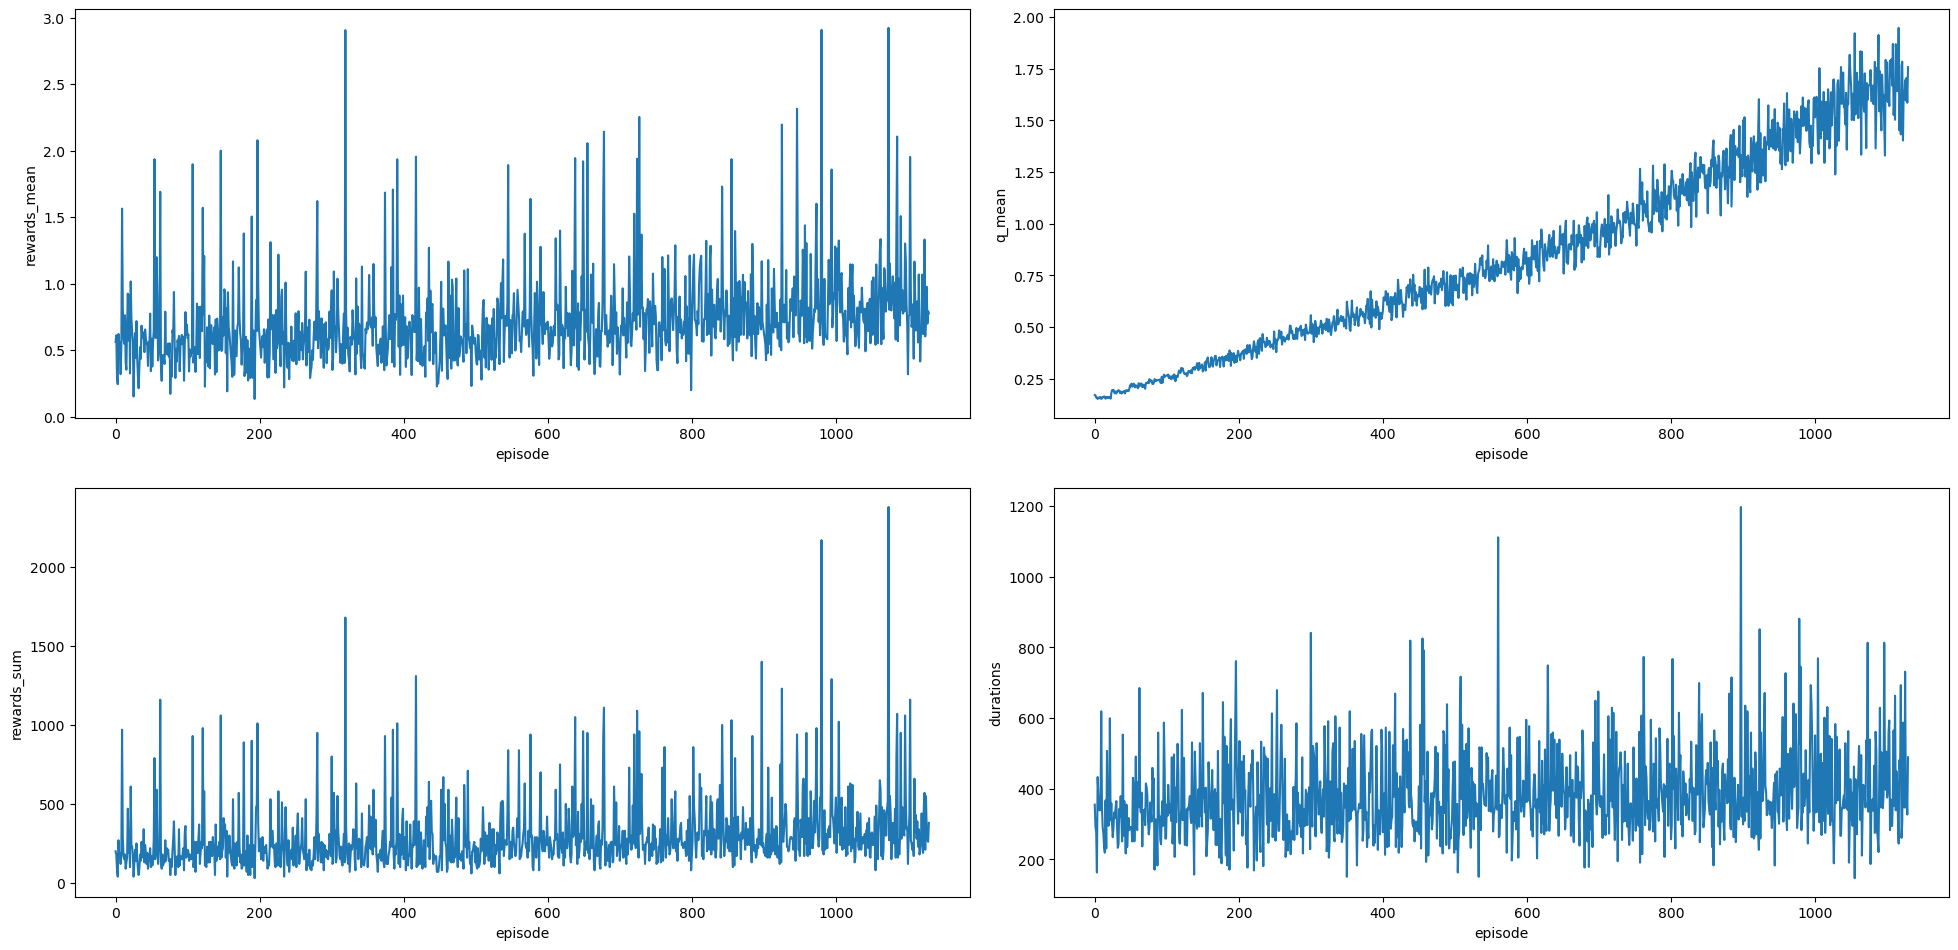

In [ ]:
import gymnasium as gym


env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array')

policy = DQN(params['sequence_size'], params['n_actions'])
target = DQN(params['sequence_size'], params['n_actions'])

memory = ReplayMemory(12000)

agent = Agent(env, policy, target, memory)

while True:
    agent.run_episode()
    agent.visualize()

In [48]:
# "Выключаем" режим исследователя.
params['epsilon_end'] = 0
params['epsilon_start'] = 0
# Запускаем один эпизод.
agent.run_episode()
# Создаем массив изображений video из текущих наблюдений агента.
video = np.array(agent.current_data['observations'])
# Создаем фигуру для отображения видео.
figure = plt.figure()
# Создаем объект images для отображения первого кадра видео.
images = plt.imshow(video[0,:,:,:])
# Закрываем фигуру, чтобы изображение не отображалось на экране.
plt.close()
# Функция init для инициализации анимации.
def init():
    images.set_data(video[0,:,:,:])
# Функция animate для обновления изображения на каждом кадре анимации.
def animate(i):
    images.set_data(video[i,:,:,:])
    return images
# Создаем анимацию с использованием библиотеки Matplotlib.
html5_video = animation.FuncAnimation(figure, animate, init_func=init, frames=video.shape[0],
interval=50).to_html5_video()
# Отображаем анимацию в ячей

AttributeError: 'torch.return_types.max' object has no attribute 'view'